# Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [ ]:
!pip install timm

In [ ]:
# !pip install albumentations==0.4.6

# Libraries

In [ ]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

# csv

In [ ]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [ ]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [ ]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)

# Hold out | Folds

In [ ]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
train_split.shape, val_split.shape

((603, 4), (297, 4))

In [ ]:
import numpy as np
from sklearn import model_selection
FOLDS = 3
kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold_, (train_idx, test_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[test_idx,'kfold'] = fold_

  train_fold = train.iloc[train_idx]
  val_fold = train.iloc[test_idx]
  train_fold.reset_index(drop=True, inplace=True)
  val_fold.reset_index(drop=True, inplace=True)
  train_fold.to_csv(f'./train_fold{FOLDS}.csv')
  val_fold.to_csv(f'./val_fold{FOLDS}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, test_idx.shape)

Fold: 1
(600,) (300,)
Fold: 2
(600,) (300,)
Fold: 3
(600,) (300,)


# Dataset class

In [ ]:
params = {
    "model": "resnet101",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "im_size": 224,
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 100,
    "lr_scheduler": True,
    "early_stopping": True
}

In [ ]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

import cv2
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    image = cv2.resize(image, (params['im_size'],params['im_size']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      image = self.transform(image=image)["image"].astype(np.float32)
      # image = self.transform(image=image)["image"]
      image = image.transpose(2, 0, 1)
    else:
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

# Data Loader

In [ ]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target']),
    'val': MelanomaDataset(train_split['path'], train_split['target'])
}

In [ ]:
train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1]))

# Show batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
  for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

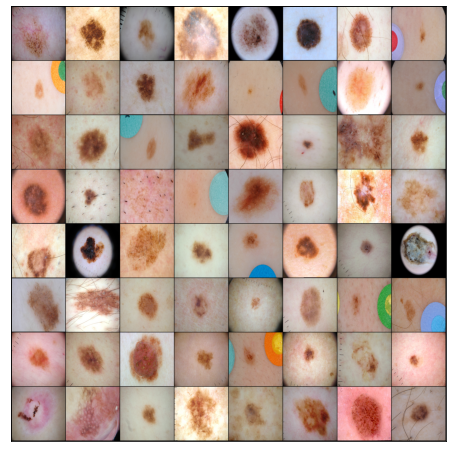

In [ ]:
show_batch(train_loader)

# Generate mean and std from dataset
mean: (0.7198314, 0.61556673, 0.5636417) \\
std: (0.16768907, 0.17222084, 0.19237213)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(dataset['train']))
print(mean)
print(std)

(0.7198314, 0.61556673, 0.5636417)
(0.16768907, 0.17222084, 0.19237213)


## compute_img_mean_std function (not used)

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    print(f'mean {means}')
    print(f'std {stds}')
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

# Augmentation

In [ ]:
mean= (0.72196096, 0.6170128, 0.56728417)
std= (0.16372901, 0.17203921, 0.19337493)


# mean= (0.7198314, 0.61556673, 0.5636417)
# std= (0.16768907, 0.17222084, 0.19237213)

In [ ]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(params['im_size'], params['im_size']),
       A.Cutout(max_h_size=int(params['im_size'] * 0.375), max_w_size=int(params['im_size'] * 0.375), num_holes=1, p=0.7),
      #  A.Normalize(mean,std)
       A.Normalize()
       ])
  
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Normalize(mean, std)
       ])
  return transforms_train, transforms_val

In [ ]:

def transform_aug(im_size):
  transforms_train = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean, std)
        # A.Normalize()
    ]
)
  
  transforms_val = A.Compose(
    [
        A.Normalize(mean, std)
    ])
  return transforms_train, transforms_val

In [ ]:
from torch.utils.data import DataLoader
transforms_train, transforms_val = transform_aug(params['im_size'])

dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target'],transform=transforms_train),
    'val': MelanomaDataset(val_split['path'], val_split['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'])

images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1]))

## Visualize augmentation

In [ ]:
import random
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1,2,0)/255.)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

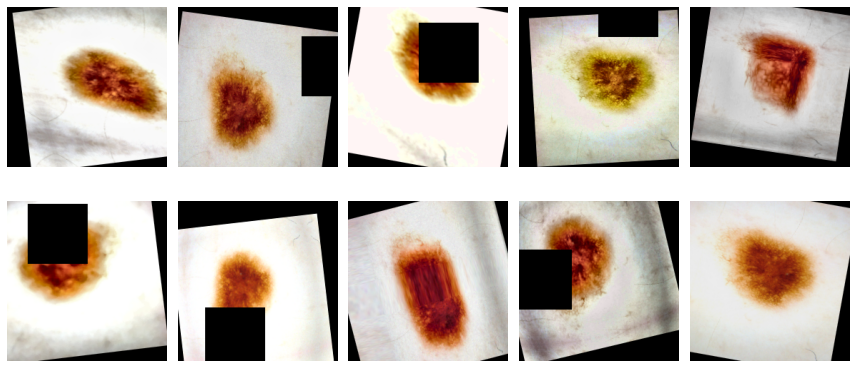

In [ ]:
import matplotlib.pyplot as plt
random.seed(42)
visualize_augmentations(dataset['train'])

# Model

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## parameters

In [ ]:
from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

optimizer = AdamP(model.parameters(), lr=params['lr'])
# criterion = BinaryCrossEntropy()

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

## Learning rate scheduler | Early stopping

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=1, mode="min", factor=0.8, min_lr=1e-7):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.mode = mode
    self.factor = factor
    self.min_lr = min_lr
    self.lr_scheduler = ReduceLROnPlateau( self.optimizer, mode='min', patience=self.patience_t, factor=self.factor, min_lr=self.min_lr, verbose=True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

### Early stopping

In [ ]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Metrics

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

def auc_score(outputs, targets):
  # outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score_(outputs, targets):
  outputs = outputs >= 0.5
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs)
  return f1

def accuracy_score(outputs, targets):
  # output = torch.sigmoid(outputs) >= 0.5
  outputs = outputs >= 0.5
  targets = targets == 1.0
  return torch.true_divide((targets == outputs).sum(dim=0), outputs.size(0)).item()

In [ ]:
from sklearn.metrics import classification_report

# Train

In [ ]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [ ]:
from statistics import mean
def train(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  train_running_loss = []
  train_running_acc = []
  train_running_auc = []
  train_running_f1 = []
  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)
    accuracy = accuracy_score(outputs, targets)
    auc = auc_score(outputs, targets)
    f1 = f1_score_(outputs, targets)    
    
    train_running_loss.append(loss.item())
    train_running_acc.append(accuracy)
    train_running_auc.append(auc)
    train_running_f1.append(f1)

    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
    metric_monitor.update("AUC", auc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("\n")
    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  return mean(train_running_loss), mean(train_running_acc), mean(train_running_f1), mean(train_running_auc)
  

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  best_=0
  val_running_loss = []
  val_running_auc = []
  val_running_acc = []
  val_running_f1 = []
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      accuracy = accuracy_score(outputs, targets)
      auc = auc_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      val_running_loss.append(loss.item())
      val_running_acc.append(accuracy)
      val_running_auc.append(auc)
      val_running_f1.append(f1)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    if f1 > best_:
      best_ = f1
      torch.save(model, f'{params["model"]}.pth')
      print(f"\nCurrent best model: {best_:.5f}\n")
  return mean(val_running_loss), mean(val_running_acc), mean(val_running_f1), mean(val_running_auc)



# Training loop

In [ ]:
from tqdm import tqdm
import time

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
start = time.time()

lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = train(train_loader, model, criterion, optimizer, epoch, params)
  val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_auc.append(val_epoch_f1);val_auc.append(val_epoch_auc)
  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1. Train. Loss: 0.692 | Accuracy: 0.750 | F1: 0.111 | AUC: 0.562:  10%|█         | 1/10 [01:16<11:29, 76.63s/it]

Epoch: 1. Train. Loss: 0.627 | Accuracy: 0.766 | F1: 0.286 | AUC: 0.688:  20%|██        | 2/10 [02:27<09:47, 73.45s/it]

Epoch: 1. Train. Loss: 0.688 | Accuracy: 0.734 | F1: 0.244 | AUC: 0.621:  30%|███       | 3/10 [03:42<08:37, 73.86s/it]

Epoch: 1. Train. Loss: 0.631 | Accuracy: 0.750 | F1: 0.278 | AUC: 0.657:  40%|████      | 4/10 [04:58<07:29, 74.97s/it]

Epoch: 1. Train. Loss: 0.689 | Accuracy: 0.738 | F1: 0.223 | AUC: 0.618:  50%|█████     | 5/10 [06:07<06:02, 72.53s/it]

Epoch: 1. Train. Loss: 0.658 | Accuracy: 0.753 | F1: 0.186 | AUC: 0.596:  60%|██████    | 6/10 [07:17<04:47, 71.97s/it]

Epoch: 1. Train. Loss: 0.674 | Accuracy: 0.748 | F1: 0.185 | AUC: 0.600:  70%|███████   | 7/10 [08:34<03:40, 73.35s/it]

Epoch: 1. Train. Loss: 0.646 | Accuracy: 0.760 | F1: 0.198 | AUC: 0.612:  80%|████████  | 8/10 [09:54<02:31, 75.56s/it]

Epoch: 1. Train. Loss: 0.634 | Accuracy: 0.759 | F1: 0.188 | AUC: 0.628:  90%|█████████ | 9/10 [11:02<01:13, 73.16s/it]

Epoch: 1. Train. Loss: 0.617 | Accuracy: 0.768 | F1: 0.169 | AUC: 0.631: 100%|██████████| 10/10 [11:32<00:00, 69.29s/it]


Epoch: 1. Validation. Loss: 1.688 | Accuracy: 0.906 | F1: 0.000 | AUC: 0.672:  10%|█         | 1/10 [00:09<01:23,  9.32s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 1.935 | Accuracy: 0.883 | F1: 0.000 | AUC: 0.710:  20%|██        | 2/10 [00:18<01:14,  9.27s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 2.057 | Accuracy: 0.880 | F1: 0.000 | AUC: 0.681:  30%|███       | 3/10 [00:27<01:03,  9.12s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 2.679 | Accuracy: 0.848 | F1: 0.000 | AUC: 0.662:  40%|████      | 4/10 [00:35<00:51,  8.51s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 2.851 | Accuracy: 0.841 | F1: 0.000 | AUC: 0.661:  50%|█████     | 5/10 [00:42<00:40,  8.16s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 2.992 | Accuracy: 0.839 | F1: 0.000 | AUC: 0.637:  60%|██████    | 6/10 [00:56<00:39,  9.96s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 3.213 | Accuracy: 0.833 | F1: 0.000 | AUC: 0.598:  70%|███████   | 7/10 [01:03<00:27,  9.24s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 3.643 | Accuracy: 0.814 | F1: 0.000 | AUC: 0.584:  80%|████████  | 8/10 [01:11<00:17,  8.68s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 3.728 | Accuracy: 0.812 | F1: 0.000 | AUC: 0.568:  90%|█████████ | 9/10 [01:18<00:08,  8.19s/it]


Current best model: 0.00000



Epoch: 1. Validation. Loss: 4.010 | Accuracy: 0.802 | F1: 0.000 | AUC: 0.550: 100%|██████████| 10/10 [01:22<00:00,  8.22s/it]



Current best model: 0.00000



Epoch: 2. Train. Loss: 0.396 | Accuracy: 0.781 | F1: 0.000 | AUC: 0.822:  10%|█         | 1/10 [00:21<03:17, 21.94s/it]

Epoch: 2. Train. Loss: 0.370 | Accuracy: 0.820 | F1: 0.000 | AUC: 0.794:  20%|██        | 2/10 [00:38<02:31, 18.99s/it]

Epoch: 2. Train. Loss: 0.378 | Accuracy: 0.823 | F1: 0.000 | AUC: 0.766:  30%|███       | 3/10 [00:55<02:06, 18.13s/it]

Epoch: 2. Train. Loss: 0.387 | Accuracy: 0.824 | F1: 0.000 | AUC: 0.765:  40%|████      | 4/10 [01:12<01:45, 17.53s/it]

Epoch: 2. Train. Loss: 0.413 | Accuracy: 0.816 | F1: 0.000 | AUC: 0.762:  50%|█████     | 5/10 [01:29<01:27, 17.48s/it]

Epoch: 2. Train. Loss: 0.433 | Accuracy: 0.810 | F1: 0.050 | AUC: 0.775:  60%|██████    | 6/10 [01:46<01:08, 17.07s/it]

Epoch: 2. Train. Loss: 0.454 | Accuracy: 0.806 | F1: 0.075 | AUC: 0.772:  70%|███████   | 7/10 [02:02<00:50, 16.96s/it]

Epoch: 2. Train. Loss: 0.436 | Accuracy: 0.816 | F1: 0.111 | AUC: 0.780:  80%|████████  | 8/10 [02:20<00:33, 17.00s/it]

Epoch: 2. Train. Loss: 0.448 | Accuracy: 0.812 | F1: 0.123 | AUC: 0.775:  90%|█████████ | 9/10 [02:36<00:16, 16.80s/it]

Epoch: 2. Train. Loss: 0.451 | Accuracy: 0.813 | F1: 0.111 | AUC: 0.755: 100%|██████████| 10/10 [02:43<00:00, 16.35s/it]


Epoch: 2. Validation. Loss: 0.633 | Accuracy: 0.859 | F1: 0.182 | AUC: 0.793:  10%|█         | 1/10 [00:07<01:10,  7.83s/it]


Current best model: 0.18182



Epoch: 2. Validation. Loss: 0.721 | Accuracy: 0.859 | F1: 0.245 | AUC: 0.780:  20%|██        | 2/10 [00:14<00:58,  7.36s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.702 | Accuracy: 0.859 | F1: 0.224 | AUC: 0.693:  30%|███       | 3/10 [00:22<00:53,  7.61s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.758 | Accuracy: 0.820 | F1: 0.192 | AUC: 0.710:  40%|████      | 4/10 [00:30<00:45,  7.56s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.835 | Accuracy: 0.812 | F1: 0.198 | AUC: 0.716:  50%|█████     | 5/10 [00:37<00:37,  7.46s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.830 | Accuracy: 0.799 | F1: 0.165 | AUC: 0.685:  60%|██████    | 6/10 [00:45<00:30,  7.72s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.847 | Accuracy: 0.797 | F1: 0.184 | AUC: 0.690:  70%|███████   | 7/10 [00:53<00:23,  7.68s/it]


Current best model: 0.30769



Epoch: 2. Validation. Loss: 0.809 | Accuracy: 0.789 | F1: 0.207 | AUC: 0.710:  80%|████████  | 8/10 [01:00<00:15,  7.59s/it]


Current best model: 0.37037



Epoch: 2. Validation. Loss: 0.818 | Accuracy: 0.790 | F1: 0.219 | AUC: 0.709:  90%|█████████ | 9/10 [01:07<00:07,  7.41s/it]


Current best model: 0.37037



Epoch: 2. Validation. Loss: 0.781 | Accuracy: 0.789 | F1: 0.237 | AUC: 0.730: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]



Current best model: 0.40000



Epoch: 3. Train. Loss: 0.375 | Accuracy: 0.781 | F1: 0.222 | AUC: 0.893:  10%|█         | 1/10 [00:17<02:35, 17.33s/it]

Epoch: 3. Train. Loss: 0.360 | Accuracy: 0.820 | F1: 0.111 | AUC: 0.871:  20%|██        | 2/10 [00:35<02:20, 17.59s/it]

Epoch: 3. Train. Loss: 0.334 | Accuracy: 0.833 | F1: 0.135 | AUC: 0.880:  30%|███       | 3/10 [00:51<01:58, 16.95s/it]

Epoch: 3. Train. Loss: 0.326 | Accuracy: 0.840 | F1: 0.146 | AUC: 0.880:  40%|████      | 4/10 [01:07<01:39, 16.63s/it]

Epoch: 3. Train. Loss: 0.328 | Accuracy: 0.841 | F1: 0.151 | AUC: 0.878:  50%|█████     | 5/10 [01:24<01:23, 16.78s/it]

Epoch: 3. Train. Loss: 0.340 | Accuracy: 0.836 | F1: 0.149 | AUC: 0.869:  60%|██████    | 6/10 [01:41<01:06, 16.72s/it]

Epoch: 3. Train. Loss: 0.334 | Accuracy: 0.835 | F1: 0.150 | AUC: 0.874:  70%|███████   | 7/10 [01:58<00:50, 16.97s/it]

Epoch: 3. Train. Loss: 0.341 | Accuracy: 0.834 | F1: 0.175 | AUC: 0.870:  80%|████████  | 8/10 [02:14<00:33, 16.55s/it]

Epoch: 3. Train. Loss: 0.373 | Accuracy: 0.823 | F1: 0.156 | AUC: 0.853:  90%|█████████ | 9/10 [02:30<00:16, 16.38s/it]

Epoch: 3. Train. Loss: 0.369 | Accuracy: 0.826 | F1: 0.174 | AUC: 0.854: 100%|██████████| 10/10 [02:37<00:00, 15.71s/it]


Epoch: 3. Validation. Loss: 0.437 | Accuracy: 0.891 | F1: 0.533 | AUC: 0.830:  10%|█         | 1/10 [00:07<01:10,  7.82s/it]


Current best model: 0.53333



Epoch: 3. Validation. Loss: 0.463 | Accuracy: 0.844 | F1: 0.484 | AUC: 0.808:  20%|██        | 2/10 [00:14<00:57,  7.23s/it]


Current best model: 0.53333



Epoch: 3. Validation. Loss: 0.477 | Accuracy: 0.823 | F1: 0.423 | AUC: 0.765:  30%|███       | 3/10 [00:22<00:52,  7.51s/it]


Current best model: 0.53333



Epoch: 3. Validation. Loss: 0.460 | Accuracy: 0.820 | F1: 0.467 | AUC: 0.789:  40%|████      | 4/10 [00:30<00:45,  7.52s/it]


Current best model: 0.60000



Epoch: 3. Validation. Loss: 0.449 | Accuracy: 0.828 | F1: 0.488 | AUC: 0.800:  50%|█████     | 5/10 [00:37<00:37,  7.44s/it]


Current best model: 0.60000



Epoch: 3. Validation. Loss: 0.467 | Accuracy: 0.831 | F1: 0.497 | AUC: 0.794:  60%|██████    | 6/10 [00:45<00:30,  7.70s/it]


Current best model: 0.60000



Epoch: 3. Validation. Loss: 0.471 | Accuracy: 0.821 | F1: 0.490 | AUC: 0.794:  70%|███████   | 7/10 [00:53<00:22,  7.66s/it]


Current best model: 0.60000



Epoch: 3. Validation. Loss: 0.477 | Accuracy: 0.812 | F1: 0.508 | AUC: 0.800:  80%|████████  | 8/10 [01:00<00:15,  7.55s/it]


Current best model: 0.63636



Epoch: 3. Validation. Loss: 0.469 | Accuracy: 0.814 | F1: 0.521 | AUC: 0.810:  90%|█████████ | 9/10 [01:07<00:07,  7.38s/it]


Current best model: 0.63636



Epoch: 3. Validation. Loss: 0.461 | Accuracy: 0.814 | F1: 0.535 | AUC: 0.816: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]



Current best model: 0.66667



Epoch: 4. Train. Loss: 0.299 | Accuracy: 0.875 | F1: 0.429 | AUC: 0.913:  10%|█         | 1/10 [00:16<02:32, 16.95s/it]

Epoch: 4. Train. Loss: 0.341 | Accuracy: 0.859 | F1: 0.487 | AUC: 0.886:  20%|██        | 2/10 [00:33<02:12, 16.54s/it]

Epoch: 4. Train. Loss: 0.325 | Accuracy: 0.865 | F1: 0.491 | AUC: 0.886:  30%|███       | 3/10 [00:50<01:58, 16.90s/it]

Epoch: 4. Train. Loss: 0.342 | Accuracy: 0.859 | F1: 0.480 | AUC: 0.861:  40%|████      | 4/10 [01:06<01:40, 16.72s/it]

Epoch: 4. Train. Loss: 0.334 | Accuracy: 0.869 | F1: 0.498 | AUC: 0.856:  50%|█████     | 5/10 [01:23<01:22, 16.50s/it]

Epoch: 4. Train. Loss: 0.339 | Accuracy: 0.865 | F1: 0.489 | AUC: 0.858:  60%|██████    | 6/10 [01:39<01:05, 16.43s/it]

Epoch: 4. Train. Loss: 0.320 | Accuracy: 0.871 | F1: 0.501 | AUC: 0.872:  70%|███████   | 7/10 [01:56<00:49, 16.58s/it]

Epoch: 4. Train. Loss: 0.335 | Accuracy: 0.859 | F1: 0.476 | AUC: 0.867:  80%|████████  | 8/10 [02:13<00:33, 16.76s/it]

Epoch: 4. Train. Loss: 0.351 | Accuracy: 0.854 | F1: 0.460 | AUC: 0.852:  90%|█████████ | 9/10 [02:29<00:16, 16.67s/it]

Epoch: 4. Train. Loss: 0.336 | Accuracy: 0.858 | F1: 0.487 | AUC: 0.867: 100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


Epoch: 4. Validation. Loss: 0.257 | Accuracy: 0.906 | F1: 0.571 | AUC: 0.868:  10%|█         | 1/10 [00:07<01:10,  7.83s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.310 | Accuracy: 0.891 | F1: 0.536 | AUC: 0.843:  20%|██        | 2/10 [00:14<00:58,  7.28s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.378 | Accuracy: 0.865 | F1: 0.440 | AUC: 0.793:  30%|███       | 3/10 [00:22<00:52,  7.54s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.435 | Accuracy: 0.852 | F1: 0.465 | AUC: 0.787:  40%|████      | 4/10 [00:30<00:45,  7.51s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.424 | Accuracy: 0.847 | F1: 0.476 | AUC: 0.802:  50%|█████     | 5/10 [00:37<00:37,  7.43s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.430 | Accuracy: 0.841 | F1: 0.473 | AUC: 0.795:  60%|██████    | 6/10 [00:45<00:30,  7.69s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.431 | Accuracy: 0.839 | F1: 0.480 | AUC: 0.801:  70%|███████   | 7/10 [00:53<00:22,  7.66s/it]


Current best model: 0.57143



Epoch: 4. Validation. Loss: 0.421 | Accuracy: 0.838 | F1: 0.509 | AUC: 0.815:  80%|████████  | 8/10 [01:00<00:15,  7.58s/it]


Current best model: 0.71795



Epoch: 4. Validation. Loss: 0.418 | Accuracy: 0.839 | F1: 0.518 | AUC: 0.818:  90%|█████████ | 9/10 [01:07<00:07,  7.41s/it]


Current best model: 0.71795



Epoch: 4. Validation. Loss: 0.399 | Accuracy: 0.836 | F1: 0.527 | AUC: 0.832: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]



Current best model: 0.71795



Epoch: 5. Train. Loss: 0.356 | Accuracy: 0.812 | F1: 0.500 | AUC: 0.930:  10%|█         | 1/10 [00:17<02:35, 17.28s/it]

Epoch: 5. Train. Loss: 0.322 | Accuracy: 0.828 | F1: 0.542 | AUC: 0.935:  20%|██        | 2/10 [00:34<02:17, 17.18s/it]

Epoch: 5. Train. Loss: 0.339 | Accuracy: 0.828 | F1: 0.520 | AUC: 0.912:  30%|███       | 3/10 [00:50<01:58, 16.87s/it]

Epoch: 5. Train. Loss: 0.327 | Accuracy: 0.840 | F1: 0.497 | AUC: 0.903:  40%|████      | 4/10 [01:06<01:39, 16.53s/it]

Epoch: 5. Train. Loss: 0.323 | Accuracy: 0.844 | F1: 0.503 | AUC: 0.902:  50%|█████     | 5/10 [01:23<01:22, 16.55s/it]

Epoch: 5. Train. Loss: 0.307 | Accuracy: 0.849 | F1: 0.530 | AUC: 0.912:  60%|██████    | 6/10 [01:40<01:06, 16.65s/it]

Epoch: 5. Train. Loss: 0.301 | Accuracy: 0.859 | F1: 0.542 | AUC: 0.907:  70%|███████   | 7/10 [01:57<00:50, 16.91s/it]

Epoch: 5. Train. Loss: 0.292 | Accuracy: 0.871 | F1: 0.580 | AUC: 0.911:  80%|████████  | 8/10 [02:14<00:33, 16.74s/it]

Epoch: 5. Train. Loss: 0.282 | Accuracy: 0.875 | F1: 0.571 | AUC: 0.914:  90%|█████████ | 9/10 [02:30<00:16, 16.59s/it]

Epoch: 5. Train. Loss: 0.311 | Accuracy: 0.865 | F1: 0.564 | AUC: 0.909: 100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


Epoch: 5. Validation. Loss: 0.202 | Accuracy: 0.906 | F1: 0.000 | AUC: 0.905:  10%|█         | 1/10 [00:07<01:09,  7.75s/it]


Current best model: 0.00000



Epoch: 5. Validation. Loss: 0.251 | Accuracy: 0.898 | F1: 0.182 | AUC: 0.908:  20%|██        | 2/10 [00:14<00:58,  7.29s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.259 | Accuracy: 0.896 | F1: 0.195 | AUC: 0.902:  30%|███       | 3/10 [00:22<00:52,  7.55s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.337 | Accuracy: 0.859 | F1: 0.146 | AUC: 0.896:  40%|████      | 4/10 [00:30<00:45,  7.51s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.347 | Accuracy: 0.853 | F1: 0.148 | AUC: 0.896:  50%|█████     | 5/10 [00:37<00:37,  7.45s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.353 | Accuracy: 0.849 | F1: 0.123 | AUC: 0.908:  60%|██████    | 6/10 [00:45<00:30,  7.70s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.359 | Accuracy: 0.842 | F1: 0.106 | AUC: 0.918:  70%|███████   | 7/10 [00:53<00:23,  7.67s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.379 | Accuracy: 0.830 | F1: 0.134 | AUC: 0.918:  80%|████████  | 8/10 [01:00<00:15,  7.55s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.376 | Accuracy: 0.828 | F1: 0.135 | AUC: 0.922:  90%|█████████ | 9/10 [01:07<00:07,  7.38s/it]


Current best model: 0.36364



Epoch: 5. Validation. Loss: 0.396 | Accuracy: 0.812 | F1: 0.122 | AUC: 0.918: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]



Current best model: 0.36364



Epoch: 6. Train. Loss: 0.151 | Accuracy: 0.953 | F1: 0.857 | AUC: 0.986:  10%|█         | 1/10 [00:16<02:29, 16.64s/it]

Epoch: 6. Train. Loss: 0.202 | Accuracy: 0.891 | F1: 0.689 | AUC: 0.981:  20%|██        | 2/10 [00:33<02:15, 16.90s/it]

Epoch: 6. Train. Loss: 0.216 | Accuracy: 0.906 | F1: 0.698 | AUC: 0.960:  30%|███       | 3/10 [00:50<01:56, 16.66s/it]

Epoch: 6. Train. Loss: 0.213 | Accuracy: 0.906 | F1: 0.698 | AUC: 0.960:  40%|████      | 4/10 [01:06<01:39, 16.59s/it]

Epoch: 6. Train. Loss: 0.216 | Accuracy: 0.903 | F1: 0.685 | AUC: 0.954:  50%|█████     | 5/10 [01:22<01:22, 16.48s/it]

Epoch: 6. Train. Loss: 0.231 | Accuracy: 0.901 | F1: 0.676 | AUC: 0.941:  60%|██████    | 6/10 [01:39<01:05, 16.48s/it]

Epoch: 6. Train. Loss: 0.234 | Accuracy: 0.891 | F1: 0.648 | AUC: 0.944:  70%|███████   | 7/10 [01:56<00:50, 16.70s/it]

Epoch: 6. Train. Loss: 0.235 | Accuracy: 0.891 | F1: 0.633 | AUC: 0.941:  80%|████████  | 8/10 [02:13<00:33, 16.78s/it]

Epoch: 6. Train. Loss: 0.241 | Accuracy: 0.887 | F1: 0.621 | AUC: 0.939:  90%|█████████ | 9/10 [02:30<00:16, 16.83s/it]

Epoch: 6. Train. Loss: 0.239 | Accuracy: 0.891 | F1: 0.634 | AUC: 0.942: 100%|██████████| 10/10 [02:37<00:00, 15.79s/it]


Epoch: 6. Validation. Loss: 0.185 | Accuracy: 0.922 | F1: 0.444 | AUC: 0.943:  10%|█         | 1/10 [00:07<01:10,  7.83s/it]


Current best model: 0.44444



Epoch: 6. Validation. Loss: 0.171 | Accuracy: 0.945 | F1: 0.667 | AUC: 0.953:  20%|██        | 2/10 [00:14<00:58,  7.34s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.194 | Accuracy: 0.927 | F1: 0.566 | AUC: 0.936:  30%|███       | 3/10 [00:22<00:53,  7.60s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.230 | Accuracy: 0.898 | F1: 0.524 | AUC: 0.933:  40%|████      | 4/10 [00:30<00:45,  7.56s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.239 | Accuracy: 0.897 | F1: 0.546 | AUC: 0.927:  50%|█████     | 5/10 [00:37<00:37,  7.47s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.237 | Accuracy: 0.896 | F1: 0.544 | AUC: 0.931:  60%|██████    | 6/10 [00:45<00:30,  7.71s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.239 | Accuracy: 0.893 | F1: 0.545 | AUC: 0.932:  70%|███████   | 7/10 [00:53<00:23,  7.67s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.238 | Accuracy: 0.889 | F1: 0.566 | AUC: 0.937:  80%|████████  | 8/10 [01:00<00:15,  7.55s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.238 | Accuracy: 0.889 | F1: 0.573 | AUC: 0.938:  90%|█████████ | 9/10 [01:07<00:07,  7.38s/it]


Current best model: 0.88889



Epoch: 6. Validation. Loss: 0.245 | Accuracy: 0.881 | F1: 0.577 | AUC: 0.938: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]



Current best model: 0.88889



Epoch: 7. Train. Loss: 0.160 | Accuracy: 0.953 | F1: 0.842 | AUC: 0.987:  10%|█         | 1/10 [00:16<02:32, 16.94s/it]

Epoch: 7. Train. Loss: 0.140 | Accuracy: 0.945 | F1: 0.859 | AUC: 0.991:  20%|██        | 2/10 [00:33<02:15, 16.97s/it]

Epoch: 7. Train. Loss: 0.189 | Accuracy: 0.922 | F1: 0.758 | AUC: 0.964:  30%|███       | 3/10 [00:51<01:59, 17.10s/it]

Epoch: 7. Train. Loss: 0.199 | Accuracy: 0.922 | F1: 0.759 | AUC: 0.959:  40%|████      | 4/10 [01:08<01:42, 17.03s/it]

Epoch: 7. Train. Loss: 0.212 | Accuracy: 0.919 | F1: 0.752 | AUC: 0.953:  50%|█████     | 5/10 [01:25<01:25, 17.07s/it]

Epoch: 7. Train. Loss: 0.211 | Accuracy: 0.919 | F1: 0.750 | AUC: 0.953:  60%|██████    | 6/10 [01:42<01:07, 16.99s/it]

Epoch: 7. Train. Loss: 0.224 | Accuracy: 0.913 | F1: 0.738 | AUC: 0.950:  70%|███████   | 7/10 [01:59<00:51, 17.06s/it]

Epoch: 7. Train. Loss: 0.226 | Accuracy: 0.914 | F1: 0.743 | AUC: 0.949:  80%|████████  | 8/10 [02:15<00:33, 16.78s/it]

Epoch: 7. Train. Loss: 0.228 | Accuracy: 0.908 | F1: 0.719 | AUC: 0.949:  90%|█████████ | 9/10 [02:32<00:16, 16.73s/it]

Epoch: 7. Train. Loss: 0.234 | Accuracy: 0.902 | F1: 0.707 | AUC: 0.946: 100%|██████████| 10/10 [02:39<00:00, 15.94s/it]


Epoch: 7. Validation. Loss: 0.095 | Accuracy: 0.969 | F1: 0.800 | AUC: 0.997:  10%|█         | 1/10 [00:07<01:10,  7.81s/it]


Current best model: 0.80000



Epoch: 7. Validation. Loss: 0.159 | Accuracy: 0.953 | F1: 0.800 | AUC: 0.974:  20%|██        | 2/10 [00:14<00:57,  7.25s/it]


Current best model: 0.80000



Epoch: 7. Validation. Loss: 0.206 | Accuracy: 0.927 | F1: 0.719 | AUC: 0.948:  30%|███       | 3/10 [00:22<00:52,  7.54s/it]


Current best model: 0.80000



Epoch: 7. Validation. Loss: 0.206 | Accuracy: 0.926 | F1: 0.743 | AUC: 0.954:  40%|████      | 4/10 [00:30<00:45,  7.55s/it]


Current best model: 0.81481



Epoch: 7. Validation. Loss: 0.228 | Accuracy: 0.919 | F1: 0.733 | AUC: 0.943:  50%|█████     | 5/10 [00:37<00:37,  7.47s/it]


Current best model: 0.81481



Epoch: 7. Validation. Loss: 0.229 | Accuracy: 0.917 | F1: 0.732 | AUC: 0.946:  60%|██████    | 6/10 [00:45<00:30,  7.71s/it]


Current best model: 0.81481



Epoch: 7. Validation. Loss: 0.226 | Accuracy: 0.920 | F1: 0.748 | AUC: 0.949:  70%|███████   | 7/10 [00:53<00:23,  7.70s/it]


Current best model: 0.84615



Epoch: 7. Validation. Loss: 0.235 | Accuracy: 0.918 | F1: 0.762 | AUC: 0.948:  80%|████████  | 8/10 [01:00<00:15,  7.62s/it]


Current best model: 0.85714



Epoch: 7. Validation. Loss: 0.230 | Accuracy: 0.922 | F1: 0.776 | AUC: 0.951:  90%|█████████ | 9/10 [01:07<00:07,  7.45s/it]


Current best model: 0.88889



Epoch: 7. Validation. Loss: 0.235 | Accuracy: 0.919 | F1: 0.779 | AUC: 0.952: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]



Current best model: 0.88889



Epoch: 8. Train. Loss: 0.119 | Accuracy: 0.953 | F1: 0.889 | AUC: 0.993:  10%|█         | 1/10 [00:16<02:24, 16.09s/it]

Epoch: 8. Train. Loss: 0.120 | Accuracy: 0.961 | F1: 0.903 | AUC: 0.994:  20%|██        | 2/10 [00:33<02:16, 17.07s/it]

Epoch: 8. Train. Loss: 0.113 | Accuracy: 0.964 | F1: 0.907 | AUC: 0.995:  30%|███       | 3/10 [00:50<01:59, 17.00s/it]

Epoch: 8. Train. Loss: 0.119 | Accuracy: 0.965 | F1: 0.903 | AUC: 0.990:  40%|████      | 4/10 [01:07<01:40, 16.79s/it]

Epoch: 8. Train. Loss: 0.122 | Accuracy: 0.963 | F1: 0.896 | AUC: 0.989:  50%|█████     | 5/10 [01:23<01:22, 16.46s/it]

Epoch: 8. Train. Loss: 0.136 | Accuracy: 0.953 | F1: 0.875 | AUC: 0.986:  60%|██████    | 6/10 [01:39<01:06, 16.50s/it]

Epoch: 8. Train. Loss: 0.159 | Accuracy: 0.944 | F1: 0.834 | AUC: 0.972:  70%|███████   | 7/10 [01:56<00:50, 16.74s/it]

Epoch: 8. Train. Loss: 0.163 | Accuracy: 0.943 | F1: 0.830 | AUC: 0.970:  80%|████████  | 8/10 [02:13<00:33, 16.84s/it]

Epoch: 8. Train. Loss: 0.157 | Accuracy: 0.944 | F1: 0.833 | AUC: 0.972:  90%|█████████ | 9/10 [02:30<00:16, 16.88s/it]

Epoch: 8. Train. Loss: 0.169 | Accuracy: 0.931 | F1: 0.804 | AUC: 0.974: 100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


Epoch: 8. Validation. Loss: 0.327 | Accuracy: 0.875 | F1: 0.429 | AUC: 0.871:  10%|█         | 1/10 [00:07<01:10,  7.84s/it]


Current best model: 0.42857



Epoch: 8. Validation. Loss: 0.396 | Accuracy: 0.859 | F1: 0.402 | AUC: 0.774:  20%|██        | 2/10 [00:14<00:57,  7.25s/it]


Current best model: 0.42857



Epoch: 8. Validation. Loss: 0.402 | Accuracy: 0.859 | F1: 0.401 | AUC: 0.781:  30%|███       | 3/10 [00:22<00:52,  7.52s/it]


Current best model: 0.42857



Epoch: 8. Validation. Loss: 0.396 | Accuracy: 0.848 | F1: 0.426 | AUC: 0.811:  40%|████      | 4/10 [00:30<00:45,  7.53s/it]


Current best model: 0.50000



Epoch: 8. Validation. Loss: 0.397 | Accuracy: 0.844 | F1: 0.453 | AUC: 0.819:  50%|█████     | 5/10 [00:37<00:37,  7.48s/it]


Current best model: 0.56000



Epoch: 8. Validation. Loss: 0.399 | Accuracy: 0.849 | F1: 0.470 | AUC: 0.813:  60%|██████    | 6/10 [00:45<00:30,  7.70s/it]


Current best model: 0.56000



Epoch: 8. Validation. Loss: 0.388 | Accuracy: 0.853 | F1: 0.488 | AUC: 0.825:  70%|███████   | 7/10 [00:53<00:23,  7.70s/it]


Current best model: 0.60000



Epoch: 8. Validation. Loss: 0.410 | Accuracy: 0.834 | F1: 0.480 | AUC: 0.816:  80%|████████  | 8/10 [01:00<00:15,  7.56s/it]


Current best model: 0.60000



Epoch: 8. Validation. Loss: 0.413 | Accuracy: 0.826 | F1: 0.459 | AUC: 0.819:  90%|█████████ | 9/10 [01:07<00:07,  7.39s/it]


Current best model: 0.60000



Epoch: 8. Validation. Loss: 0.428 | Accuracy: 0.822 | F1: 0.470 | AUC: 0.813: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]



Current best model: 0.60000

INFO: Early stopping counter 1 of 5


Epoch: 9. Train. Loss: 0.197 | Accuracy: 0.906 | F1: 0.750 | AUC: 0.967:  10%|█         | 1/10 [00:16<02:25, 16.17s/it]

Epoch: 9. Train. Loss: 0.147 | Accuracy: 0.945 | F1: 0.830 | AUC: 0.981:  20%|██        | 2/10 [00:31<02:07, 15.93s/it]

Epoch: 9. Train. Loss: 0.122 | Accuracy: 0.958 | F1: 0.872 | AUC: 0.987:  30%|███       | 3/10 [00:48<01:54, 16.31s/it]

Epoch: 9. Train. Loss: 0.130 | Accuracy: 0.938 | F1: 0.827 | AUC: 0.989:  40%|████      | 4/10 [01:05<01:39, 16.54s/it]

Epoch: 9. Train. Loss: 0.129 | Accuracy: 0.941 | F1: 0.833 | AUC: 0.989:  50%|█████     | 5/10 [01:22<01:24, 16.84s/it]

Epoch: 9. Train. Loss: 0.131 | Accuracy: 0.940 | F1: 0.837 | AUC: 0.988:  60%|██████    | 6/10 [01:39<01:07, 16.86s/it]

Epoch: 9. Train. Loss: 0.133 | Accuracy: 0.940 | F1: 0.838 | AUC: 0.988:  70%|███████   | 7/10 [01:56<00:49, 16.66s/it]

Epoch: 9. Train. Loss: 0.145 | Accuracy: 0.939 | F1: 0.831 | AUC: 0.980:  80%|████████  | 8/10 [02:12<00:33, 16.58s/it]

Epoch: 9. Train. Loss: 0.138 | Accuracy: 0.944 | F1: 0.845 | AUC: 0.982:  90%|█████████ | 9/10 [02:30<00:16, 16.87s/it]

Epoch: 9. Train. Loss: 0.132 | Accuracy: 0.950 | F1: 0.861 | AUC: 0.984: 100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


Epoch: 9. Validation. Loss: 0.059 | Accuracy: 0.984 | F1: 0.909 | AUC: 1.000:  10%|█         | 1/10 [00:07<01:10,  7.87s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.066 | Accuracy: 0.977 | F1: 0.892 | AUC: 0.997:  20%|██        | 2/10 [00:14<00:58,  7.28s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.082 | Accuracy: 0.969 | F1: 0.861 | AUC: 0.992:  30%|███       | 3/10 [00:22<00:52,  7.55s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.107 | Accuracy: 0.957 | F1: 0.850 | AUC: 0.988:  40%|████      | 4/10 [00:30<00:45,  7.53s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.106 | Accuracy: 0.956 | F1: 0.851 | AUC: 0.990:  50%|█████     | 5/10 [00:37<00:37,  7.43s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.111 | Accuracy: 0.956 | F1: 0.850 | AUC: 0.987:  60%|██████    | 6/10 [00:45<00:30,  7.68s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.121 | Accuracy: 0.949 | F1: 0.832 | AUC: 0.985:  70%|███████   | 7/10 [00:53<00:22,  7.67s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.140 | Accuracy: 0.945 | F1: 0.835 | AUC: 0.979:  80%|████████  | 8/10 [01:00<00:15,  7.54s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.137 | Accuracy: 0.946 | F1: 0.839 | AUC: 0.981:  90%|█████████ | 9/10 [01:07<00:07,  7.37s/it]


Current best model: 0.90909



Epoch: 9. Validation. Loss: 0.143 | Accuracy: 0.944 | F1: 0.841 | AUC: 0.980: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]



Current best model: 0.90909



Epoch: 10. Train. Loss: 0.088 | Accuracy: 0.969 | F1: 0.933 | AUC: 0.995:  10%|█         | 1/10 [00:16<02:27, 16.35s/it]

Epoch: 10. Train. Loss: 0.070 | Accuracy: 0.977 | F1: 0.933 | AUC: 0.997:  20%|██        | 2/10 [00:33<02:13, 16.65s/it]

Epoch: 10. Train. Loss: 0.072 | Accuracy: 0.964 | F1: 0.900 | AUC: 0.997:  30%|███       | 3/10 [00:49<01:55, 16.52s/it]

Epoch: 10. Train. Loss: 0.072 | Accuracy: 0.965 | F1: 0.900 | AUC: 0.998:  40%|████      | 4/10 [01:06<01:39, 16.53s/it]

Epoch: 10. Train. Loss: 0.067 | Accuracy: 0.969 | F1: 0.907 | AUC: 0.998:  50%|█████     | 5/10 [01:22<01:21, 16.35s/it]

Epoch: 10. Train. Loss: 0.073 | Accuracy: 0.964 | F1: 0.897 | AUC: 0.997:  60%|██████    | 6/10 [01:39<01:06, 16.71s/it]

Epoch: 10. Train. Loss: 0.079 | Accuracy: 0.958 | F1: 0.890 | AUC: 0.998:  70%|███████   | 7/10 [01:56<00:49, 16.67s/it]

Epoch: 10. Train. Loss: 0.075 | Accuracy: 0.959 | F1: 0.892 | AUC: 0.998:  80%|████████  | 8/10 [02:13<00:33, 16.89s/it]

Epoch: 10. Train. Loss: 0.081 | Accuracy: 0.960 | F1: 0.894 | AUC: 0.995:  90%|█████████ | 9/10 [02:30<00:16, 16.95s/it]

Epoch: 10. Train. Loss: 0.083 | Accuracy: 0.960 | F1: 0.896 | AUC: 0.996: 100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


Epoch: 10. Validation. Loss: 0.203 | Accuracy: 0.922 | F1: 0.286 | AUC: 0.951:  10%|█         | 1/10 [00:07<01:10,  7.83s/it]


Current best model: 0.28571



Epoch: 10. Validation. Loss: 0.275 | Accuracy: 0.922 | F1: 0.451 | AUC: 0.910:  20%|██        | 2/10 [00:14<00:58,  7.31s/it]


Current best model: 0.61538



Epoch: 10. Validation. Loss: 0.211 | Accuracy: 0.932 | F1: 0.557 | AUC: 0.940:  30%|███       | 3/10 [00:22<00:53,  7.62s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.301 | Accuracy: 0.895 | F1: 0.473 | AUC: 0.943:  40%|████      | 4/10 [00:30<00:45,  7.56s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.329 | Accuracy: 0.884 | F1: 0.436 | AUC: 0.947:  50%|█████     | 5/10 [00:37<00:37,  7.45s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.335 | Accuracy: 0.880 | F1: 0.414 | AUC: 0.951:  60%|██████    | 6/10 [00:45<00:30,  7.69s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.371 | Accuracy: 0.871 | F1: 0.376 | AUC: 0.949:  70%|███████   | 7/10 [00:53<00:23,  7.68s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.450 | Accuracy: 0.850 | F1: 0.341 | AUC: 0.941:  80%|████████  | 8/10 [01:00<00:15,  7.56s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.501 | Accuracy: 0.845 | F1: 0.319 | AUC: 0.924:  90%|█████████ | 9/10 [01:07<00:07,  7.38s/it]


Current best model: 0.76923



Epoch: 10. Validation. Loss: 0.510 | Accuracy: 0.842 | F1: 0.341 | AUC: 0.923: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]



Current best model: 0.76923

INFO: Early stopping counter 1 of 5


Epoch: 11. Train. Loss: 0.058 | Accuracy: 1.000 | F1: 1.000 | AUC: 1.000:  10%|█         | 1/10 [00:17<02:37, 17.55s/it]

Epoch: 11. Train. Loss: 0.057 | Accuracy: 0.984 | F1: 0.964 | AUC: 0.999:  20%|██        | 2/10 [00:33<02:14, 16.75s/it]

Epoch: 11. Train. Loss: 0.053 | Accuracy: 0.990 | F1: 0.976 | AUC: 1.000:  30%|███       | 3/10 [00:49<01:54, 16.30s/it]

Epoch: 11. Train. Loss: 0.078 | Accuracy: 0.969 | F1: 0.929 | AUC: 0.997:  40%|████      | 4/10 [01:05<01:37, 16.28s/it]

Epoch: 11. Train. Loss: 0.093 | Accuracy: 0.963 | F1: 0.906 | AUC: 0.995:  50%|█████     | 5/10 [01:22<01:23, 16.61s/it]

Epoch: 11. Train. Loss: 0.096 | Accuracy: 0.961 | F1: 0.893 | AUC: 0.995:  60%|██████    | 6/10 [01:40<01:07, 16.76s/it]

Epoch: 11. Train. Loss: 0.128 | Accuracy: 0.955 | F1: 0.870 | AUC: 0.988:  70%|███████   | 7/10 [01:56<00:50, 16.75s/it]

Epoch: 11. Train. Loss: 0.157 | Accuracy: 0.949 | F1: 0.865 | AUC: 0.983:  80%|████████  | 8/10 [02:13<00:33, 16.62s/it]

Epoch: 11. Train. Loss: 0.154 | Accuracy: 0.946 | F1: 0.853 | AUC: 0.984:  90%|█████████ | 9/10 [02:29<00:16, 16.64s/it]

Epoch: 11. Train. Loss: 0.153 | Accuracy: 0.940 | F1: 0.848 | AUC: 0.985: 100%|██████████| 10/10 [02:37<00:00, 15.72s/it]


Epoch: 11. Validation. Loss: 1.118 | Accuracy: 0.719 | F1: 0.400 | AUC: 0.894:  10%|█         | 1/10 [00:07<01:10,  7.87s/it]


Current best model: 0.40000



Epoch: 11. Validation. Loss: 1.352 | Accuracy: 0.672 | F1: 0.414 | AUC: 0.879:  20%|██        | 2/10 [00:14<00:58,  7.32s/it]


Current best model: 0.42857



Epoch: 11. Validation. Loss: 1.434 | Accuracy: 0.672 | F1: 0.410 | AUC: 0.847:  30%|███       | 3/10 [00:22<00:52,  7.56s/it]


Current best model: 0.42857



Epoch: 11. Validation. Loss: 1.382 | Accuracy: 0.668 | F1: 0.447 | AUC: 0.846:  40%|████      | 4/10 [00:30<00:45,  7.57s/it]


Current best model: 0.56000



Epoch: 11. Validation. Loss: 1.327 | Accuracy: 0.678 | F1: 0.463 | AUC: 0.854:  50%|█████     | 5/10 [00:37<00:37,  7.46s/it]


Current best model: 0.56000



Epoch: 11. Validation. Loss: 1.309 | Accuracy: 0.677 | F1: 0.471 | AUC: 0.870:  60%|██████    | 6/10 [00:45<00:30,  7.68s/it]


Current best model: 0.56000



Epoch: 11. Validation. Loss: 1.292 | Accuracy: 0.683 | F1: 0.485 | AUC: 0.868:  70%|███████   | 7/10 [00:53<00:23,  7.69s/it]


Current best model: 0.57143



Epoch: 11. Validation. Loss: 1.319 | Accuracy: 0.678 | F1: 0.504 | AUC: 0.872:  80%|████████  | 8/10 [01:00<00:15,  7.58s/it]


Current best model: 0.63492



Epoch: 11. Validation. Loss: 1.321 | Accuracy: 0.668 | F1: 0.501 | AUC: 0.874:  90%|█████████ | 9/10 [01:07<00:07,  7.39s/it]


Current best model: 0.63492



Epoch: 11. Validation. Loss: 1.300 | Accuracy: 0.676 | F1: 0.521 | AUC: 0.882: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]



Current best model: 0.69565

Epoch    11: reducing learning rate of group 0 to 8.0000e-04.
INFO: Early stopping counter 2 of 5


Epoch: 12. Train. Loss: 0.078 | Accuracy: 0.969 | F1: 0.917 | AUC: 0.998:  10%|█         | 1/10 [00:16<02:28, 16.48s/it]

Epoch: 12. Train. Loss: 0.161 | Accuracy: 0.930 | F1: 0.838 | AUC: 0.975:  20%|██        | 2/10 [00:32<02:09, 16.17s/it]

Epoch: 12. Train. Loss: 0.136 | Accuracy: 0.938 | F1: 0.839 | AUC: 0.982:  30%|███       | 3/10 [00:48<01:52, 16.10s/it]

Epoch: 12. Train. Loss: 0.146 | Accuracy: 0.941 | F1: 0.849 | AUC: 0.978:  40%|████      | 4/10 [01:05<01:39, 16.51s/it]

Epoch: 12. Train. Loss: 0.123 | Accuracy: 0.950 | F1: 0.869 | AUC: 0.982:  50%|█████     | 5/10 [01:22<01:24, 16.82s/it]

Epoch: 12. Train. Loss: 0.122 | Accuracy: 0.948 | F1: 0.860 | AUC: 0.984:  60%|██████    | 6/10 [01:39<01:07, 16.85s/it]

Epoch: 12. Train. Loss: 0.126 | Accuracy: 0.949 | F1: 0.863 | AUC: 0.982:  70%|███████   | 7/10 [01:55<00:49, 16.61s/it]

Epoch: 12. Train. Loss: 0.123 | Accuracy: 0.953 | F1: 0.874 | AUC: 0.984:  80%|████████  | 8/10 [02:12<00:33, 16.62s/it]

Epoch: 12. Train. Loss: 0.125 | Accuracy: 0.951 | F1: 0.871 | AUC: 0.984:  90%|█████████ | 9/10 [02:29<00:16, 16.75s/it]

Epoch: 12. Train. Loss: 0.115 | Accuracy: 0.956 | F1: 0.884 | AUC: 0.986: 100%|██████████| 10/10 [02:37<00:00, 15.72s/it]


Epoch: 12. Validation. Loss: 0.369 | Accuracy: 0.844 | F1: 0.375 | AUC: 0.868:  10%|█         | 1/10 [00:07<01:10,  7.81s/it]


Current best model: 0.37500



Epoch: 12. Validation. Loss: 0.326 | Accuracy: 0.875 | F1: 0.551 | AUC: 0.914:  20%|██        | 2/10 [00:14<00:58,  7.32s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.297 | Accuracy: 0.885 | F1: 0.576 | AUC: 0.917:  30%|███       | 3/10 [00:22<00:52,  7.57s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.344 | Accuracy: 0.852 | F1: 0.539 | AUC: 0.899:  40%|████      | 4/10 [00:30<00:45,  7.53s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.361 | Accuracy: 0.844 | F1: 0.531 | AUC: 0.887:  50%|█████     | 5/10 [00:37<00:37,  7.44s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.340 | Accuracy: 0.854 | F1: 0.554 | AUC: 0.897:  60%|██████    | 6/10 [00:45<00:30,  7.69s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.332 | Accuracy: 0.853 | F1: 0.553 | AUC: 0.900:  70%|███████   | 7/10 [00:53<00:22,  7.66s/it]


Current best model: 0.72727



Epoch: 12. Validation. Loss: 0.339 | Accuracy: 0.852 | F1: 0.576 | AUC: 0.900:  80%|████████  | 8/10 [01:00<00:15,  7.59s/it]


Current best model: 0.73684



Epoch: 12. Validation. Loss: 0.343 | Accuracy: 0.849 | F1: 0.581 | AUC: 0.902:  90%|█████████ | 9/10 [01:07<00:07,  7.40s/it]


Current best model: 0.73684



Epoch: 12. Validation. Loss: 0.336 | Accuracy: 0.853 | F1: 0.605 | AUC: 0.908: 100%|██████████| 10/10 [01:11<00:00,  7.14s/it]



Current best model: 0.82353

INFO: Early stopping counter 3 of 5


Epoch: 13. Train. Loss: 0.139 | Accuracy: 0.953 | F1: 0.800 | AUC: 0.960:  10%|█         | 1/10 [00:27<04:04, 27.16s/it]

Epoch: 13. Train. Loss: 0.146 | Accuracy: 0.953 | F1: 0.821 | AUC: 0.963:  20%|██        | 2/10 [00:43<02:47, 20.91s/it]

Epoch: 13. Train. Loss: 0.121 | Accuracy: 0.958 | F1: 0.850 | AUC: 0.975:  30%|███       | 3/10 [01:00<02:12, 19.00s/it]

Epoch: 13. Train. Loss: 0.104 | Accuracy: 0.965 | F1: 0.878 | AUC: 0.981:  40%|████      | 4/10 [01:16<01:47, 17.94s/it]

Epoch: 13. Train. Loss: 0.105 | Accuracy: 0.963 | F1: 0.878 | AUC: 0.984:  50%|█████     | 5/10 [01:34<01:28, 17.73s/it]

Epoch: 13. Train. Loss: 0.106 | Accuracy: 0.961 | F1: 0.875 | AUC: 0.984:  60%|██████    | 6/10 [01:50<01:08, 17.24s/it]

Epoch: 13. Train. Loss: 0.111 | Accuracy: 0.955 | F1: 0.862 | AUC: 0.985:  70%|███████   | 7/10 [02:07<00:51, 17.12s/it]

Epoch: 13. Train. Loss: 0.105 | Accuracy: 0.959 | F1: 0.875 | AUC: 0.986:  80%|████████  | 8/10 [02:23<00:33, 16.98s/it]

Epoch: 13. Train. Loss: 0.110 | Accuracy: 0.953 | F1: 0.865 | AUC: 0.985:  90%|█████████ | 9/10 [02:40<00:16, 16.99s/it]

Epoch: 13. Train. Loss: 0.111 | Accuracy: 0.950 | F1: 0.862 | AUC: 0.986: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it]


Epoch: 13. Validation. Loss: 0.111 | Accuracy: 0.953 | F1: 0.667 | AUC: 0.974:  10%|█         | 1/10 [00:07<01:09,  7.76s/it]


Current best model: 0.66667



Epoch: 13. Validation. Loss: 0.128 | Accuracy: 0.945 | F1: 0.690 | AUC: 0.982:  20%|██        | 2/10 [00:14<00:58,  7.28s/it]


Current best model: 0.71429



Epoch: 13. Validation. Loss: 0.146 | Accuracy: 0.938 | F1: 0.665 | AUC: 0.973:  30%|███       | 3/10 [00:22<00:52,  7.55s/it]


Current best model: 0.71429



Epoch: 13. Validation. Loss: 0.180 | Accuracy: 0.918 | F1: 0.651 | AUC: 0.977:  40%|████      | 4/10 [00:30<00:45,  7.55s/it]


Current best model: 0.71429



Epoch: 13. Validation. Loss: 0.181 | Accuracy: 0.922 | F1: 0.681 | AUC: 0.980:  50%|█████     | 5/10 [00:37<00:37,  7.49s/it]


Current best model: 0.80000



Epoch: 13. Validation. Loss: 0.177 | Accuracy: 0.917 | F1: 0.656 | AUC: 0.982:  60%|██████    | 6/10 [00:45<00:30,  7.75s/it]


Current best model: 0.80000



Epoch: 13. Validation. Loss: 0.185 | Accuracy: 0.911 | F1: 0.648 | AUC: 0.981:  70%|███████   | 7/10 [00:53<00:23,  7.72s/it]


Current best model: 0.80000



Epoch: 13. Validation. Loss: 0.196 | Accuracy: 0.904 | F1: 0.658 | AUC: 0.980:  80%|████████  | 8/10 [01:00<00:15,  7.60s/it]


Current best model: 0.80000



Epoch: 13. Validation. Loss: 0.199 | Accuracy: 0.905 | F1: 0.663 | AUC: 0.979:  90%|█████████ | 9/10 [01:07<00:07,  7.44s/it]


Current best model: 0.80000



Epoch: 13. Validation. Loss: 0.230 | Accuracy: 0.896 | F1: 0.658 | AUC: 0.974: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]



Current best model: 0.80000

Epoch    13: reducing learning rate of group 0 to 6.4000e-04.
INFO: Early stopping counter 4 of 5


Epoch: 14. Train. Loss: 0.024 | Accuracy: 1.000 | F1: 1.000 | AUC: 1.000:  10%|█         | 1/10 [00:16<02:27, 16.39s/it]

Epoch: 14. Train. Loss: 0.051 | Accuracy: 0.992 | F1: 0.984 | AUC: 0.998:  20%|██        | 2/10 [00:33<02:12, 16.59s/it]

Epoch: 14. Train. Loss: 0.066 | Accuracy: 0.990 | F1: 0.970 | AUC: 0.997:  30%|███       | 3/10 [00:50<01:58, 16.90s/it]

Epoch: 14. Train. Loss: 0.069 | Accuracy: 0.988 | F1: 0.965 | AUC: 0.997:  40%|████      | 4/10 [01:07<01:41, 16.95s/it]

Epoch: 14. Train. Loss: 0.063 | Accuracy: 0.988 | F1: 0.966 | AUC: 0.998:  50%|█████     | 5/10 [01:24<01:24, 16.99s/it]

Epoch: 14. Train. Loss: 0.061 | Accuracy: 0.987 | F1: 0.965 | AUC: 0.998:  60%|██████    | 6/10 [01:41<01:08, 17.00s/it]

Epoch: 14. Train. Loss: 0.056 | Accuracy: 0.989 | F1: 0.970 | AUC: 0.998:  70%|███████   | 7/10 [01:58<00:50, 16.89s/it]

Epoch: 14. Train. Loss: 0.059 | Accuracy: 0.988 | F1: 0.967 | AUC: 0.998:  80%|████████  | 8/10 [02:15<00:33, 16.98s/it]

Epoch: 14. Train. Loss: 0.066 | Accuracy: 0.983 | F1: 0.954 | AUC: 0.997:  90%|█████████ | 9/10 [02:31<00:16, 16.77s/it]

Epoch: 14. Train. Loss: 0.064 | Accuracy: 0.984 | F1: 0.958 | AUC: 0.997: 100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


Epoch: 14. Validation. Loss: 0.065 | Accuracy: 0.953 | F1: 0.667 | AUC: 1.000:  10%|█         | 1/10 [00:07<01:10,  7.81s/it]


Current best model: 0.66667



Epoch: 14. Validation. Loss: 0.103 | Accuracy: 0.945 | F1: 0.690 | AUC: 0.998:  20%|██        | 2/10 [00:14<00:58,  7.30s/it]


Current best model: 0.71429



Epoch: 14. Validation. Loss: 0.092 | Accuracy: 0.948 | F1: 0.717 | AUC: 0.999:  30%|███       | 3/10 [00:22<00:53,  7.62s/it]


Current best model: 0.76923



Epoch: 14. Validation. Loss: 0.125 | Accuracy: 0.934 | F1: 0.718 | AUC: 0.998:  40%|████      | 4/10 [00:30<00:45,  7.57s/it]


Current best model: 0.76923



Epoch: 14. Validation. Loss: 0.145 | Accuracy: 0.922 | F1: 0.674 | AUC: 0.998:  50%|█████     | 5/10 [00:37<00:37,  7.45s/it]


Current best model: 0.76923



Epoch: 14. Validation. Loss: 0.177 | Accuracy: 0.914 | F1: 0.633 | AUC: 0.997:  60%|██████    | 6/10 [00:45<00:30,  7.67s/it]


Current best model: 0.76923



Epoch: 14. Validation. Loss: 0.166 | Accuracy: 0.920 | F1: 0.667 | AUC: 0.998:  70%|███████   | 7/10 [00:53<00:23,  7.67s/it]


Current best model: 0.86957



Epoch: 14. Validation. Loss: 0.169 | Accuracy: 0.912 | F1: 0.672 | AUC: 0.998:  80%|████████  | 8/10 [01:00<00:15,  7.54s/it]


Current best model: 0.86957



Epoch: 14. Validation. Loss: 0.172 | Accuracy: 0.913 | F1: 0.682 | AUC: 0.998:  90%|█████████ | 9/10 [01:07<00:07,  7.35s/it]


Current best model: 0.86957



Epoch: 14. Validation. Loss: 0.189 | Accuracy: 0.903 | F1: 0.669 | AUC: 0.998: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


Current best model: 0.86957

INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training time: 62.836 minutes


# Visuals

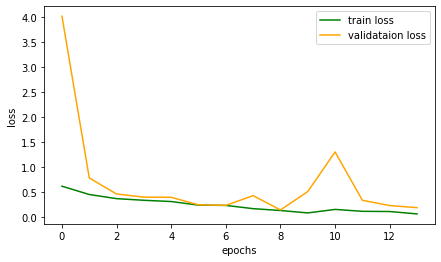

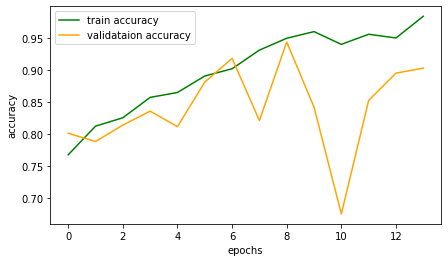

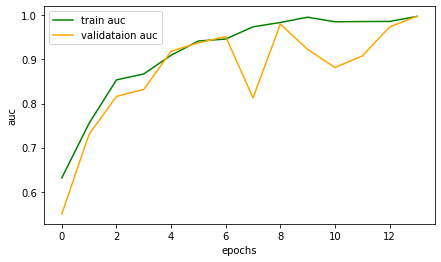

In [ ]:
import matplotlib.pyplot as plt

metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
for i in range(len(names)):
  plt.figure(figsize=(7, 4))
  plt.plot(metrics[i][0], color='green', label=f'train {names[i]}')
  plt.plot(metrics[i][1], color='orange', label=f'validataion {names[i]}')
  plt.xlabel('epochs')
  plt.ylabel(names[i])
  plt.legend()
  plt.savefig(f"./{names[i]}.png")
  plt.show()

# Test

In [ ]:
test_dataset = MelanomaDataset(test['path'], test['target'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

In [ ]:
images, labels = next(iter(test_loader))
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1]))

In [ ]:
model = torch.load(f'{params['model']}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    imgs, targets = batch
    imgs, targets = imgs.to(params['device']), targets.to(params['device'])
    outputs = model(imgs)
    preds = torch.cat([preds, outputs.view(-1)])

    val_outputs = torch.cat([val_outputs, outputs.cpu()])
    val_targets = torch.cat([val_targets, targets.cpu()])
    # stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  auc = auc_score(val_outputs, val_targets)
  print("auc:",auc)

100%|██████████| 6/6 [05:24<00:00, 54.01s/it]

auc: 0.7471929824561403


In [ ]:
plot_labels = ['bening', 'malignant']
val_outputs = val_outputs >= 0.5
report = classification_report(val_targets, val_outputs, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

      bening       0.82      0.98      0.89       304
   malignant       0.63      0.16      0.26        75

    accuracy                           0.82       379
   macro avg       0.73      0.57      0.57       379
weighted avg       0.79      0.82      0.77       379

